In [56]:
from src.data.pipelines import convnet_pipeline
from src.models import early_convnet

import os
import datetime

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [53]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [64]:
# rm -rf ./logs/

In [51]:
## Parameters
# Pipeline
BATCH_SIZE_IMAGES = 1
BATCH_SIZE_PATCHES = 1
IMAGE_SIZE = 612
PATCH_SIZE = 40
PATCH_SIZE_ANNOTATION = 2
PATCH_STRIDE = 20
SLICE_TRAIN = ':10'
SLICE_VALID = '10:12'
SLICE_TEST = '12:20'

# Training
EPOCHS = 4
CHECKPOINT_FILEPATH = os.path.join(os.getcwd(), 'models', 'ckpt', 'early_convnet', 'weights.{epoch:02d}-{val_loss:.2f}.ckpt')
CLASS_WEIGHTS = {
        0: 6.070,    # urban_land
        1: 1.,       # agriculture_land
        2: 5.559,    # rangeland
        3: 4.128,    # forest_land
        4: 15.176,   # water
        5: 9.244,    # barren_land
        6: 100.       # unknown - Note: not to scale with respect to the others but not that important for the overall classification
}

In [65]:
input_pipeline = convnet_pipeline.ConvnetPipeline(
    SLICE_TRAIN,
    SLICE_VALID,
    SLICE_TEST,
    BATCH_SIZE_IMAGES,
    BATCH_SIZE_PATCHES,
    IMAGE_SIZE,
    PATCH_SIZE,
    PATCH_SIZE_ANNOTATION,
    PATCH_STRIDE
)

In [5]:
def display(display_list):
    plt.figure(figsize=(3, 3))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [6]:
for i, m in input_pipeline.train.unbatch().take(1):
    print(tf.reduce_all(tf.argmax(m, axis=2)!=1))

tf.Tensor(False, shape=(), dtype=bool)


In [66]:
train_min = input_pipeline.train.unbatch().shuffle(buffer_size=20000).filter(lambda i, m: tf.reduce_all(tf.argmax(m, axis=2)!=1)).batch(BATCH_SIZE_PATCHES)
valid_min = input_pipeline.valid.unbatch().filter(lambda i, m: tf.reduce_all(tf.argmax(m, axis=2)!=1)).batch(BATCH_SIZE_PATCHES)

In [67]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [68]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

model = early_convnet.EarlyConvnet()
model.build((None, PATCH_SIZE, PATCH_SIZE, 3))
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['mse', tf.keras.metrics.CategoricalCrossentropy(name='cce')]
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_FILEPATH,
    save_weights_only=True,
    monitor='val_cce',
    save_freq='epoch'
)

model.fit(
    train_min,
    epochs=EPOCHS,
    validation_data=valid_min,
    class_weight=CLASS_WEIGHTS,
    callbacks=[tensorboard_callback]
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/4
2790/2790 [==============================] - 37s 11ms/step - loss: 8.9900 - mse: 0.0995 - cce: 1.3486 - val_loss: 0.9763 - val_mse: 0.0788 - val_cce: 0.9763
Epoch 2/4
2790/2790 [==============================] - 25s 7ms/step - loss: 7.9116 - mse: 0.0909 - cce: 1.1941 - val_loss: 1.0131 - val_mse: 0.0784 - val_cce: 1.0131
Epoch 3/4
2790/2790 [==============================] - 27s 8ms/step - loss: 7.6482 - mse: 0.0877 - cce: 1.1487 - val_loss: 1.0783 - val_mse: 0.0834 - val_cce: 1.0783
Epoch 4/4
2790/2790 [==============================] - 26s 8ms/step - loss: 7.4124 - mse: 0.0847 - cce: 1.1123 - val_loss: 1.0922 - val_mse: 0.0879 - val_cce: 1.0922


27/27 [==============================] - 0s 8ms/step
1


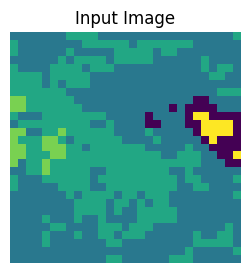

1


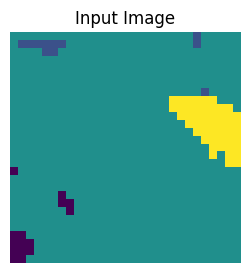

27/27 [==============================] - 0s 8ms/step
1


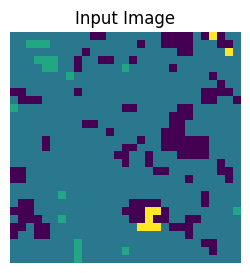

1


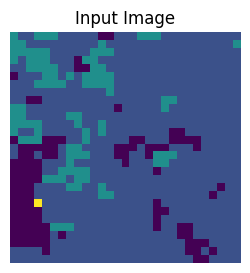

In [91]:
for i, m in input_pipeline.test.take(2):
    # print(tf.unique(tf.argmax(tf.reshape(m, shape=[-1, 7]), axis=1)))
    gt = m
    y = model.predict(i)
    gt_mask = tf.reshape(tf.argmax(input=gt, axis=3), shape=(1, 29, 29, 1))
    mask = tf.reshape(tf.argmax(input=y, axis=3), shape=(1, 29, 29, 1))
    display(mask)
    display(gt_mask)

In [85]:
y.shape

(841, 1, 1, 7)

In [89]:
gt_mask = tf.reshape(tf.argmax(input=gt, axis=3), shape=(1, 29, 29, 1))

1


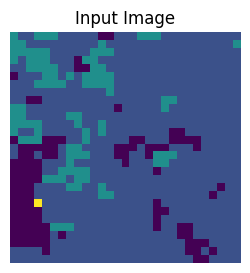

In [90]:
display(gt_mask)

1


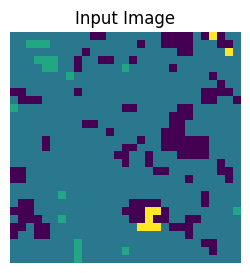

In [75]:
mask = tf.reshape(tf.argmax(input=y, axis=3), shape=(1, 29, 29, 1))
display(mask)

In [48]:
for i, m in train_min.take(1):
    y = model.predict(i)

1/1 [==============================] - 0s 103ms/step


In [50]:
tf.argmax(y, axis=3)

<tf.Tensor: shape=(1, 1, 1), dtype=int64, numpy=array([[[4]]])>